In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import dateutil
import warnings

## Modules for ML:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

# Don't collapse Pandas Dataframes:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
## Load Inventory Dataset into DataFrame:
inventory_dataset = pd.read_csv('dataset/inventory-dataset.csv')
# inventory_dataset.set_index('movie_id')

## Clean Inventory Dataset:
inventory_dataset = inventory_dataset[['movie_id','title','release_date','ratings_average','ratings_count','price','buy_probability','unknown','Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']] # Reorder DataFrame columns
inventory_dataset = inventory_dataset[inventory_dataset['buy_probability'].notna()] # Remove NA values
inventory_dataset = inventory_dataset.sort_values(by='movie_id', ascending=True)
null_release_dates = inventory_dataset[inventory_dataset['release_date'].isnull()] # Remove Null Values
inventory_dataset['release_date'] = pd.to_datetime(inventory_dataset['release_date']) # Converts string to DateTime

## Load 'Instances, Features, Labels' Dataset into DataFrame:
## Instance = UserID
## Features == Outcome (Purchase)
## Labels == Outcome Value (0 / 1)
#### Positive Outcome == (1) Purchase
#### Negative Outcome == (0) No Purchase
feature_dataset = pd.read_csv('dataset/feature-dataset.csv', index_col=0)
feature_dataset = feature_dataset.rename(columns={'Unnamed: 0.1': 'User ID'})
feature_dataset.head()

,User ID,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,price,ratings_average,ratings_count,release_date,unknown,outcome
0,10674,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.283637,0.158870,-0.615657,0.253620,0.0,0
1,13705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.283637,0.122887,0.056199,0.464156,0.0,1
2,10621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.344357,0.862546,-0.690307,0.534335,0.0,1
3,12469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.777083,-0.843335,-0.441472,0.393978,0.0,1
4,11538,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.344357,1.182399,-0.727633,0.464156,0.0,0


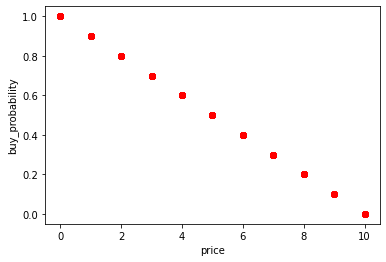

In [3]:
## Example of what Perfect Ranking would look like via inventory_dataset (assuming users will make their buy_decision based ONLY on price)
## In this example: lower price = higher buy_decision
plt.plot(inventory_dataset['price'].values, inventory_dataset['buy_probability'].values, 'ro') # ro = red circles
plt.xlabel('price')
plt.ylabel('buy_probability')
plt.show()

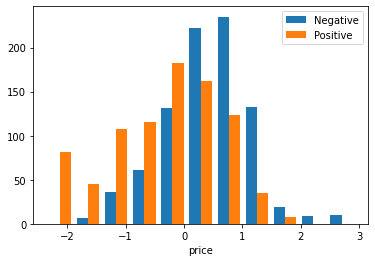

In [4]:
## Plot Sample Distribution of Positive and Negative Instances per User: (Note: 'price' is normalized)
feature_dataset_sample = feature_dataset.sample(frac=0.1)
negative_outcomes = feature_dataset_sample[feature_dataset_sample['outcome'] == 0.0]['price']
positive_outcomes = feature_dataset_sample[feature_dataset_sample['outcome'] == 1.0]['price']
outcomes = np.array(list(zip(negative_outcomes.values, positive_outcomes.values)))
plt.hist(outcomes, bins=11, label = ['Negative', 'Positive'])
plt.legend()
plt.xlabel('price')
plt.show()

In [5]:
inventory_feature_columns = inventory_dataset.columns.values.tolist()
inventory_feature_columns.remove('movie_id')
inventory_feature_columns.remove('title')

inventory_feature_columns.remove('buy_probability')

In [6]:
print('\nFeature Dataset Columns (X): {0}'.format(inventory_feature_columns))

#######################################################
## Split Dataset into Training and Validation Datasets:
def split_into_training_and_validation_dataset(feature_dataset, inventory_feature_columns):
    X = feature_dataset.loc[:, inventory_feature_columns].values.astype(np.float32)
    print('\nFeature Dataset Shape: (instances, features)')
    print('Total Dataset shape (X): {0}'.format(X.shape))
    print(X)
    y = feature_dataset.loc[:, ['outcome']].values.astype(np.float32).ravel() # Outcome = 1/0; Success/Failure
    print('\nTrue Outcomes (Examples) shape (y): {0}'.format(y.shape))
    print(y)
    print('\n')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # From Module: sklearn.model_selection; test_size = % allocated to Validation Dataset
    print('Training Dataset Split: used for Training Model')
    print('Training Dataset shape (X_train): {0}'.format(X_train.shape))
    print('Training Outcome shape (y_train): {0}'.format(y_train.shape))
    print('\n')
    print('Validation Dataset Split: used for Validating Model; do NOT learn anything about Validation Dataset')
    print('Validation Dataset shape (X_test): {0}'.format(X_test.shape))
    print('Validation Outcome shape (y_test): {0}'.format(y_test.shape))
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_into_training_and_validation_dataset(feature_dataset, inventory_feature_columns)



Feature Dataset Columns (X): ['release_date', 'ratings_average', 'ratings_count', 'price', 'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

Feature Dataset Shape: (instances, features)
Total Dataset shape (X): (19980, 23)
[[ 0.25362018  0.15887037 -0.6156566  ...  0.          0.
   0.        ]
 [ 0.46415627  0.12288694  0.0561989  ...  1.          0.
   0.        ]
 [ 0.53433496  0.86254627 -0.69030726 ...  0.          0.
   0.        ]
 ...
 [-3.6763864   0.8061017  -0.5285643  ...  0.          0.
   0.        ]
 [ 0.39397758  0.19823685 -0.57833135 ...  0.          0.
   0.        ]
 [ 0.46415627 -1.3764224  -0.51612246 ...  0.          0.
   0.        ]]

True Outcomes (Examples) shape (y): (19980,)
[0. 1. 1. ... 1. 0. 1.]


Training Dataset Split: used for Training Model
Training Dataset shape (X_train): (15984, 23)
Trai

In [7]:
# #######################################################
# ## Normalize the Training Dataset: (buy_probability is removed so that it's NOT used as training data)
def normalize_training_dataset(inventory_dataset):
    feature_columns = np.setdiff1d(inventory_dataset.columns, np.array(['title', 'buy_probability']))
    training_dataset = inventory_dataset.loc[:, feature_columns]
    scaler = StandardScaler()
    training_dataset.loc[:, ('price')] = scaler.fit_transform(training_dataset[['price']])
    training_dataset['ratings_average'] = scaler.fit_transform(training_dataset[['ratings_average']])
    training_dataset['ratings_count'] = scaler.fit_transform(training_dataset[['ratings_count']])
    training_dataset['release_date'] = training_dataset['release_date'].apply(lambda x: x.year)
    training_dataset['release_date'] = scaler.fit_transform(training_dataset[['release_date']])
    return training_dataset

training_dataset = normalize_training_dataset(inventory_dataset)
training_dataset = training_dataset[['movie_id','release_date','ratings_average','ratings_count','price','unknown','Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']] # Reorder DataFrame columns
training_dataset = training_dataset.drop(['movie_id'], axis=1) # Remove Instances
training_dataset.head()

,release_date,ratings_average,ratings_count,price,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
142,0.393978,1.026718,4.883605,1.344357,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
914,0.393978,0.166684,0.889797,0.283637,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
926,0.393978,-0.054365,0.379685,0.283637,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
316,0.393978,0.606970,1.860255,0.813997,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
924,0.393978,0.289787,0.329918,0.283637,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [8]:
#######################################################
## Train Model:
def train_model(model, prediction_function, X_train, y_train, X_test, y_test):
    print('\nModel Selected: {0}'.format(model))
    ## Fit Model:
    print('\nFitting Model...')
    print('"Overfitting" is what happens when you’ve memorized your old data so perfectly that when you release your system to operate on new data it will crash and burn because it only works on old data and not new data.')
    print('"Underfitting" is when clearly your model is performing badly (or not at the level of the performance metric criteria you previously decided).')
    model.fit(X_train, y_train) # This must happen to fit the model
    
    print('\nTraining Model...')
    print('\nTraining Data (y_train): {0}'.format(y_train.shape))
    print('Number of Dimensions: {0}'.format(y_train.ndim))
    print(y_train)
    
    y_train_pred = prediction_function(model, X_train)
    print('\nTraining Data Predictions (y_train_pred): {0}'.format(y_train_pred.shape))
    print('Number of Dimensions: {0}'.format(y_train_pred.ndim))
    print(y_train_pred)
    
#     y_train_pred_1col = y_train_pred[:,0]
#     print('\nTraining Data Predictions Single Column (y_train_pred): {0}'.format(y_train_pred_1col.shape))
#     print(y_train_pred_1col)
#     y_train_pred = y_train_pred_1col
    
    print('Training Data Precision: {0}'.format(precision_score(y_train, y_train_pred)))
    print('Training Data Recall: {0}'.format(recall_score(y_train, y_train_pred)))
    print('Training Data Accuracy: {0}'.format(accuracy_score(y_train, y_train_pred)))
    
    
    
    print('\n')
    print('_____________________')
    print('_____________________')
    print('\nValidating Model...')
    y_test_pred = prediction_function(model, X_test)
    
    
    ## Note: IF Data is being used for Validation THEN do NOT show that data !!!
    print('\nValidation Data (y_test): {0}'.format(y_test.shape))
    print('Number of Dimensions: {0}'.format(y_test.ndim))
    print(y_test)
    
    y_test_pred = prediction_function(model, X_test)
    print('\nValidation Data Predictions (y_test_pred): {0}'.format(y_test_pred.shape))
    print('Number of Dimensions: {0}'.format(y_test_pred.ndim))
    print(y_test_pred)
    
#     y_test_pred_1col = y_test_pred[:,0]
#     print('\nValidation Data Predictions Single Column (y_test_pred): {0}'.format(y_test_pred.shape))
#     print(y_test_pred_1col)
#     y_test_pred = y_test_pred_1col
    
    print('Validation Precision: {0}'.format(precision_score(y_test, y_test_pred)))
    print('Validation Recall: {0}'.format(recall_score(y_test, y_test_pred)))
    print('Validation Accuracy: {0}'.format(accuracy_score(y_test, y_test_pred)))
    return model

def prediction_function(model, data):
    print('\nprediction_function = model')
    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)

def get_predicted_rank(model, data):
    return model.predict_proba(data)[:, 1]

#########################################
## 'model' variable: LogisticRegression()

trained_model = train_model(LogisticRegression(), prediction_function, X_train, y_train, X_test, y_test)



Model Selected: LogisticRegression()

Fitting Model...
"Overfitting" is what happens when you’ve memorized your old data so perfectly that when you release your system to operate on new data it will crash and burn because it only works on old data and not new data.
"Underfitting" is when clearly your model is performing badly (or not at the level of the performance metric criteria you previously decided).

Training Model...

Training Data (y_train): (15984,)
Number of Dimensions: 1
[1. 0. 0. ... 0. 0. 0.]

prediction_function = model

Training Data Predictions (y_train_pred): (15984,)
Number of Dimensions: 1
[1. 0. 0. ... 1. 1. 0.]
Training Data Precision: 0.6747907949790795
Training Data Recall: 0.7266276188330705
Training Data Accuracy: 0.6536536536536537


_____________________
_____________________

Validating Model...

prediction_function = model

Validation Data (y_test): (3996,)
Number of Dimensions: 1
[1. 0. 0. ... 0. 1. 1.]

prediction_function = model

Validation Data Predic

Training Features Dataset shape (instances, features): (1681, 23)


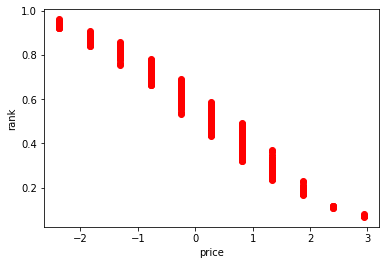

In [9]:
#######################################################
## Validate Model:
features = ['price']

training_features_dataset = training_dataset.values.astype(np.float32)
print('Training Features Dataset shape (instances, features): {0}'.format(training_features_dataset.shape))

prediction_dataset = training_dataset.copy()
prediction_dataset['rank'] = get_predicted_rank(trained_model, training_features_dataset) # Plotted DataFrame

for idx, feature in enumerate(features):
    plt.subplot(len(features), 1, idx + 1)
    plt.plot(prediction_dataset[features].values, 
             prediction_dataset['rank'].values, 
             'ro')
    plt.xlabel(feature)
    plt.ylabel('rank')

plt.show()